#### NLTK

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import PunktSentenceTokenizer
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
paragraph = \
'''
The life sciences encompass a broad spectrum of scientific disciplines concerned with the study of living organisms, from microorganisms to complex ecosystems. This field is fundamentally driven by the pursuit of understanding the intricate mechanisms of life, including their structure, function, growth, origin, evolution, and distribution. Life sciences play a pivotal role in advancing human health through the development of pharmaceuticals, medical technologies, and therapies. Furthermore, these disciplines are crucial for addressing global challenges such as food security, environmental sustainability, and the understanding of biological diversity. With ongoing advancements in technologies like genomics, biotechnology, and bioinformatics, the life sciences continue to expand our knowledge of the living world and offer innovative solutions to improve the quality of life. 
'''

In [3]:
sentences = sent_tokenize(paragraph)
words = word_tokenize(paragraph)
tokens = word_tokenize(sentences[0])
tags = nltk.pos_tag(tokens)
freqdist = nltk.FreqDist(word_tokenize(paragraph))

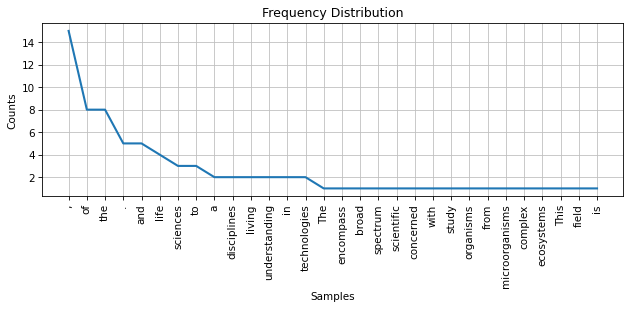

In [4]:
def plot_figure(freqdist):
  plt.figure(figsize=(10,3), dpi=75)
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title('Frequency Distribution')
  freqdist.plot(30, cumulative=False)
  plt.show()
plot_figure(freqdist)

In [5]:
''' cleaner text '''
STOPWORDS = stopwords.words()
def cleaner_text(text):
  if type(text) == str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text_tokens = word_tokenize(text)
    # Handle empty tokens_wo_stopwords
    tokens_wo_stopwords = [word for word in text_tokens if not word in STOPWORDS]
    if not tokens_wo_stopwords:  # if tokens_wo_stopwords is empty
        return ""  # Return empty string to avoid None
    filtered_sentence = (" ").join(tokens_wo_stopwords)
    return filtered_sentence
  # Handle non-string inputs
  else:
    return ""  # or handle them appropriately for your use case
filtered_sentence = cleaner_text(paragraph)

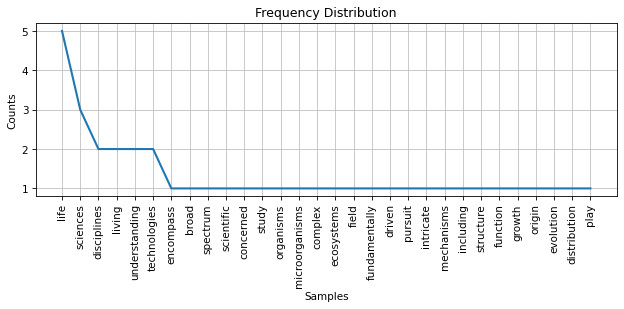

In [6]:
freqdist = nltk.FreqDist(word_tokenize(filtered_sentence))
plot_figure(freqdist)

In [ ]:
nlp = en_core_web_sm.load()
spacy_paragraph = nlp(paragraph)
[(X.text, X.label_) for X in spacy_paragraph.ents]

In [ ]:
sentences = [sentence for sentence in spacy_paragraph.sents]
displacy.render(nlp(str(sentences)), style='ent', jupyter=True)

In [9]:
displacy.render(nlp(str(sentences)), style='dep', jupyter=True, options={'distance':120})

#### Structured Data

In [ ]:
!pip install pymed
import pymed

In [58]:
from pymed import PubMed
pubmed = PubMed()
def dataset(query, num_results):
  results = pubmed.query(query, max_results=num_results)
  article_list = []
  for article in results:
    article_dict = article.toDict()
    article_list.append(article_dict)
  #print('Number of articles:', len(article_list))
  return pd.DataFrame(article_list)

df_1 = dataset('covid-19', 100)
df_2 = dataset('machine learning', 100)
df_3 = dataset('monoclonal antibodies', 100)
df_4 = dataset('cancer', 1000)

dataset('cancer', 10)[:2]

,pubmed_id,title,abstract,keywords,journal,publication_date,authors,methods,conclusions,results,copyrights,doi,xml
0,40014379,100+ years of phase variation: the premier bac...,"Stochastic, reversible switches in the express...","[bistability, contingency loci, instability, l...","Microbiology (Reading, England)",2025-02-27,"[{'lastname': 'Bayliss', 'firstname': 'Christo...",None,None,None,None,10.1099/mic.0.001537,"[[[], [<Element 'Year' at 0x7a96a5e48590>, <El..."
1,40014375,Impact of race/ethnicity on MammaPrint genomic...,Black race is associated with poorer prognosis...,"[breast cancer, estrogen receptor, ethnicity, ...",Cancer,2025-02-27,"[{'lastname': 'Patel', 'firstname': 'Rima B', ...",None,None,"Of the 6137 women included, 82.8% (n = 5084) w...",© 2025 American Cancer Society.,10.1002/cncr.35771,"[[[], [<Element 'Year' at 0x7a96c3743d30>, <El..."


In [59]:
df = pd.concat([df_1, df_2, df_3, df_4])
df = df[['title', 'abstract']]
df['text'] = df['title'] + ' ' + df['abstract']
df.head()[:2]

,title,abstract,text
0,Regarding 'long-term cognitive and autonomic e...,None,NaN
1,Telehealth-Facilitated Mental Health Care Acce...,,Telehealth-Facilitated Mental Health Care Acce...


In [60]:
df.text.str.len().mean(), #df.text.str.split(" ").apply(len).mean()

(1513.7624869018512,)

In [61]:
df['text'] = df['text'].apply(lambda t: cleaner_text(t))

In [62]:
df.text.str.len().mean()

1068.4923333333334

#### Text Clustering

In [63]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [64]:
vectors = TfidfVectorizer(stop_words='english', max_features=5500)
vectors.fit(df.text.values)
features = vectors.transform(df.text.values)
classifier = MiniBatchKMeans(n_clusters=4)
classifier.fit(features)
df['cluster'] = classifier.predict(features)
vectors, features, features.shape, classifier

(TfidfVectorizer(max_features=5500, stop_words='english'),
 <3000x5500 sparse matrix of type '<class 'numpy.float64'>'
 	with 214027 stored elements in Compressed Sparse Row format>,
 (3000, 5500),
 MiniBatchKMeans(n_clusters=4))

In [65]:
vectors, features, classifier

(TfidfVectorizer(max_features=5500, stop_words='english'),
 <3000x5500 sparse matrix of type '<class 'numpy.float64'>'
 	with 214027 stored elements in Compressed Sparse Row format>,
 MiniBatchKMeans(n_clusters=4))

In [66]:
df.head()[:2]

,title,abstract,text,cluster
0,Regarding 'long-term cognitive and autonomic e...,None,,1
1,Telehealth-Facilitated Mental Health Care Acce...,,telehealth facilitated mental health access co...,0


In [67]:
pca = PCA(n_components=2)
pca_features_2d = pca.fit_transform(features.toarray())
pca_features_2d_centers = pca.transform(classifier.cluster_centers_)
df['PC1'], df['PC2'] = pca_features_2d[:,0], pca_features_2d[:,1]
df = df[['text', 'cluster', 'PC1', 'PC2']]
df.shape, pca_features_2d.shape, pca_features_2d_centers.shape

((3000, 4), (3000, 2), (4, 2))

In [29]:
df[1:3]

,text,cluster,PC1,PC2
1,telehealth facilitated mental health access co...,3,-0.009859,0.089005
2,tolerability clinical outcomes anesthesia dose...,2,-0.154634,0.164278


In [68]:
import matplotlib
cmap_min, cmap_max, n = 0.3, 1.0, 10
cmap_orig = plt.cm.Blues
colors = cmap_orig(np.linspace(cmap_min, cmap_max, n))
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('new_cmap', colors)

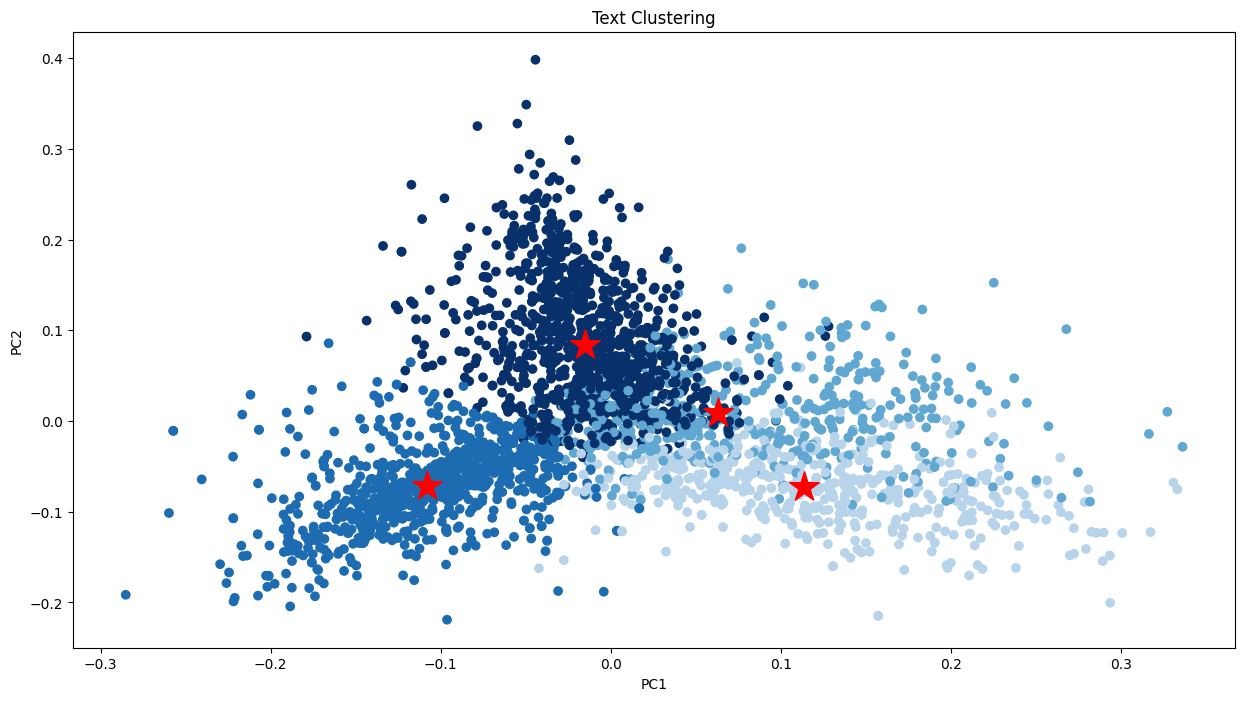

In [69]:
plt.figure(figsize=(15, 8))
plt.scatter(df['PC1'], df['PC2'], c=df['cluster'], cmap=new_cmap)
plt.scatter(pca_features_2d_centers[:,0], pca_features_2d_centers[:,1], marker='*', s=500, c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Text Clustering')
plt.show()

### Unstructured Data